# Evaluation Metrics for Binary Class

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('telco_customer_churn.csv')

df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

df.totalcharges = pd.to_numeric(df.totalcharges, errors ='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner','dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8055358410220014

## Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [10]:
len(y_val)

1409

In [17]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [21]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


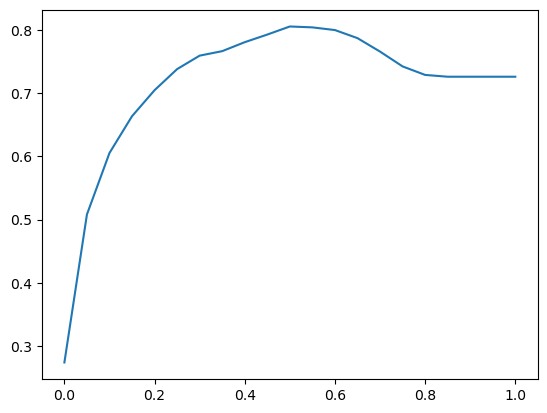

In [14]:
plt.plot(thresholds, scores)

In [22]:
y_pred >= 1.0

array([False, False, False, ..., False, False, False])

In [23]:
from collections import Counter

In [24]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

## Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [25]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [26]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [29]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [31]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [32]:
tp, tn, fp, fn

(212, 923, 100, 174)

In [33]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [35]:
confusion_matrix / confusion_matrix.sum()

array([[0.65507452, 0.07097232],
       [0.12349184, 0.15046132]])

## Precision and Recall

In [38]:
p = tp / (tp + fp)
p

0.6794871794871795

In [39]:
r = tp / (tp + fn)
r

0.5492227979274611

In [40]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

## ROC Curves

Receiver Operating Characteristics

### TPR and FPR

True Positive Rate (TPR)
False Positive Rate (FPR)
https://en.wikipedia.org/wiki/Receiver_operating_characteristic
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [41]:
tpr = tp / (tp + fn)
tpr

0.5492227979274611

In [43]:
fpr = fp / (fp + tn)
fpr

0.09775171065493646

In [55]:
## compute for all possible thresholds
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [56]:
columns = ['thresholds','tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [59]:
df_scores[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,537,19,486,0.950777,0.524927
20,0.2,337,367,49,656,0.873057,0.358749
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,252,175,134,848,0.652850,0.171065
50,0.5,212,100,174,923,0.549223,0.097752
60,0.6,155,51,231,972,0.401554,0.049853
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


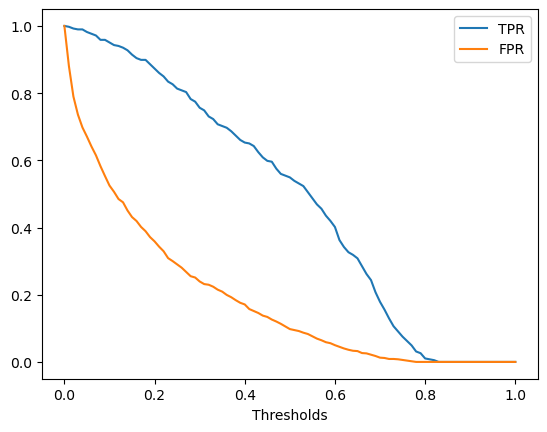

In [62]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR')
plt.xlabel("Thresholds")
plt.legend()

#### Random model

In [63]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [64]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [65]:
def tpr_fpr_dataframe(y_val, y_pred):
    ## compute for all possible thresholds
    scores = []
    
    thresholds = np.linspace(0,1,101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ['thresholds','tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [66]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [67]:
df_rand[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


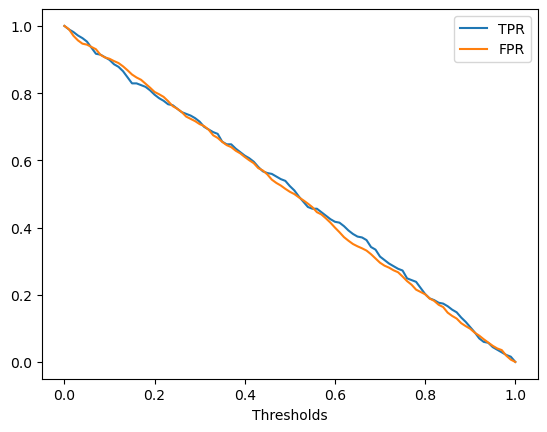

In [68]:
plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')
plt.xlabel("Thresholds")
plt.legend()

#### Ideal model

In [69]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [70]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [71]:
y_ideal_pred = np.linspace(0,1, len(y_val))

In [73]:
1 - y_val.mean()

0.7260468417317246

In [74]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [75]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

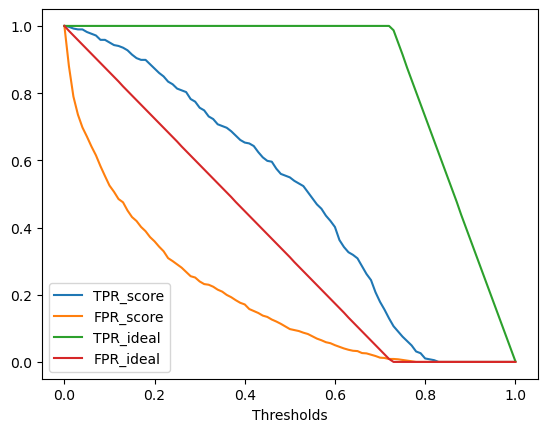

In [79]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR_score')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR_score')

# plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label='TPR_ideal')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label='FPR_ideal')

plt.xlabel("Thresholds")
plt.legend()

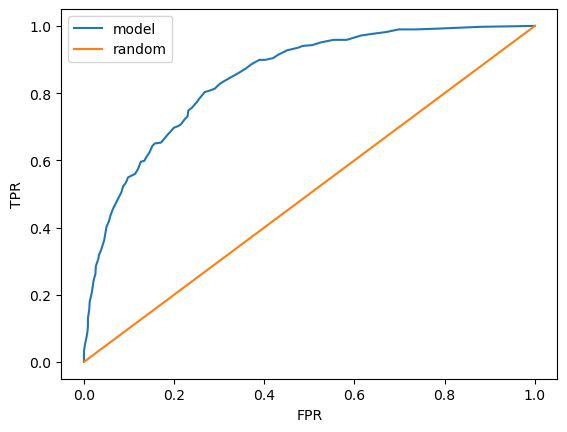

In [86]:
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label = 'random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

We want the curve to be as close to the ideal spot and far as possible from the random spot

In [87]:
from sklearn.metrics import roc_curve

In [88]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

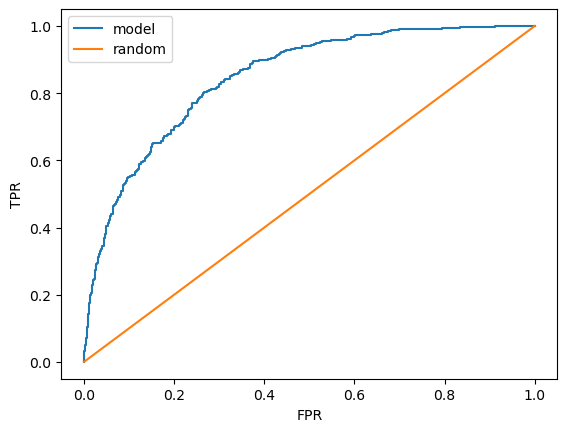

In [89]:
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label = 'random')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## ROC AUC

In [90]:
from sklearn.metrics import auc

In [91]:
auc(fpr, tpr)

0.8465956573929162

In [92]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [93]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [97]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8465956573929162

In [98]:
from sklearn.metrics import roc_auc_score

In [99]:
roc_auc_score(y_val, y_pred)

0.8465956573929162

In [100]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [101]:
import random

AUC = probability that randomly selected positive example has higher score than randomly selected negative example

In [105]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg) -1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84789

In [109]:
n=100000
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

In [110]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.84374

## Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [137]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

In [138]:
dv, model = train(df_train, y_train, C=0.001)

In [139]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [140]:
y_pred = predict(df_val, dv, model)

In [135]:
from tqdm.auto import tqdm

C:\Users\lowke\anaconda3\envs\ml_zoom\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [133]:
from sklearn.model_selection import KFold

In [141]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|████████████                                                                        | 1/7 [00:02<00:12,  2.10s/it]

C=0.001 0.825 +- 0.013


 29%|████████████████████████                                                            | 2/7 [00:03<00:09,  1.86s/it]

C=0.01 0.839 +- 0.009


 43%|████████████████████████████████████                                                | 3/7 [00:05<00:07,  1.80s/it]

C=0.1 0.841 +- 0.007


 57%|████████████████████████████████████████████████                                    | 4/7 [00:07<00:05,  1.72s/it]

C=0.5 0.841 +- 0.007


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:08<00:03,  1.70s/it]

C=1 0.841 +- 0.007


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:10<00:01,  1.71s/it]

C=5 0.841 +- 0.007


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.74s/it]

C=10 0.841 +- 0.007


In [142]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8579400803839363